In [1]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tv = TvDatafeed()

you are using nologin method, data you access may be limited


In [3]:
daxdf = tv.get_hist("DAX", "XETR", Interval.in_30_minute, 5000)
daxdf.reset_index(inplace=True)
daxdf = daxdf[["datetime", "open", "high", "low", "close"]][3:]
daxdf.head()

,datetime,open,high,low,close
3,2021-03-03 09:00:00,14130.86,14179.96,14129.55,14164.03
4,2021-03-03 09:30:00,14164.50,14185.35,14152.44,14170.13
5,2021-03-03 10:00:00,14170.00,14197.49,14161.18,14179.74
6,2021-03-03 10:30:00,14179.60,14188.59,14161.69,14170.11
7,2021-03-03 11:00:00,14171.30,14177.65,14159.54,14163.32


In [4]:
daxdf["date"] = daxdf.datetime.dt.date

In [5]:
daxdf.head()

,datetime,open,high,low,close,date
3,2021-03-03 09:00:00,14130.86,14179.96,14129.55,14164.03,2021-03-03
4,2021-03-03 09:30:00,14164.50,14185.35,14152.44,14170.13,2021-03-03
5,2021-03-03 10:00:00,14170.00,14197.49,14161.18,14179.74,2021-03-03
6,2021-03-03 10:30:00,14179.60,14188.59,14161.69,14170.11,2021-03-03
7,2021-03-03 11:00:00,14171.30,14177.65,14159.54,14163.32,2021-03-03


In [6]:
open_time = time(9,0)
close_time = time(17, 30)
ibclose_time = time(10, 0)

daily_open = daxdf[daxdf.datetime.dt.time == open_time][["date", "open"]]
daily_close = daxdf[daxdf.datetime.dt.time == close_time][["date", "close"]]
ib_close = daxdf[daxdf.datetime.dt.time == ibclose_time][["date", "close"]].rename(
    columns={"close" : "ibclose"}
)

daily_low = daxdf.groupby("date").low.min().reset_index()
daily_high = daxdf.groupby("date").high.max().reset_index()

ib_low = daxdf[daxdf.datetime.dt.time <= ibclose_time].groupby("date").low.min().reset_index().rename(columns={"low": "iblow"})
ib_high = daxdf[daxdf.datetime.dt.time <= ibclose_time].groupby("date").high.max().reset_index().rename(columns={"high" : "ibhigh"})

In [7]:
data = reduce(
    lambda l, r : pd.merge(l,r, on="date"),
    [daily_open, daily_high, daily_low, daily_close, ib_low, ib_high, ib_close]
)

In [8]:
data

,date,open,high,low,close,iblow,ibhigh,ibclose
0,2021-03-03,14130.86,14197.49,13979.73,14080.03,14129.55,14197.49,14179.74
1,2021-03-04,14015.44,14095.81,13959.27,14056.34,13976.44,14056.32,14006.65
2,2021-03-05,13958.54,14068.03,13868.20,13920.69,13868.20,13970.17,13901.60
3,2021-03-08,14024.57,14402.92,13977.13,14380.91,13977.13,14050.00,14013.16
4,2021-03-09,14345.51,14475.65,14309.35,14437.94,14309.35,14403.48,14392.05
...,...,...,...,...,...,...,...,...
272,2022-03-28,14376.00,14627.58,14371.90,14417.37,14371.90,14527.01,14504.18
273,2022-03-29,14592.74,14925.25,14553.71,14820.33,14553.71,14664.29,14603.33
274,2022-03-30,14712.32,14744.72,14555.87,14606.05,14586.01,14744.72,14620.20
275,2022-03-31,14674.83,14732.00,14404.03,14414.75,14603.31,14732.00,14607.18


In [9]:
data["range"] = data.high - data.low
data["ibrange"] = data.ibhigh - data.iblow

In [10]:
data["daydir"] = data.apply(
    lambda r: "up" if r.close >= r.open else "down",
    axis=1
)
data["ibdir"] = data.apply(
    lambda r: "up" if r.ibclose >= r.open else "down",
    axis=1
)

def get_ibdaytype(r):
    if r.high == r.ibhigh and r.low == r.iblow:
        return "not-broken"
    if r.high == r.ibhigh:
        return "low-broken"
    if r.low == r.iblow:
        return "high-broken"
    return "both-broken"

data["ibdaytype"] = data.apply(get_ibdaytype, axis=1)

In [11]:
data

,date,open,high,low,close,iblow,ibhigh,ibclose,range,ibrange,daydir,ibdir,ibdaytype
0,2021-03-03,14130.86,14197.49,13979.73,14080.03,14129.55,14197.49,14179.74,217.76,67.94,down,up,low-broken
1,2021-03-04,14015.44,14095.81,13959.27,14056.34,13976.44,14056.32,14006.65,136.54,79.88,up,down,both-broken
2,2021-03-05,13958.54,14068.03,13868.20,13920.69,13868.20,13970.17,13901.60,199.83,101.97,down,down,high-broken
3,2021-03-08,14024.57,14402.92,13977.13,14380.91,13977.13,14050.00,14013.16,425.79,72.87,up,down,high-broken
4,2021-03-09,14345.51,14475.65,14309.35,14437.94,14309.35,14403.48,14392.05,166.30,94.13,up,up,high-broken
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2022-03-28,14376.00,14627.58,14371.90,14417.37,14371.90,14527.01,14504.18,255.68,155.11,up,up,high-broken
273,2022-03-29,14592.74,14925.25,14553.71,14820.33,14553.71,14664.29,14603.33,371.54,110.58,up,up,high-broken
274,2022-03-30,14712.32,14744.72,14555.87,14606.05,14586.01,14744.72,14620.20,188.85,158.71,down,down,low-broken
275,2022-03-31,14674.83,14732.00,14404.03,14414.75,14603.31,14732.00,14607.18,327.97,128.69,down,down,low-broken


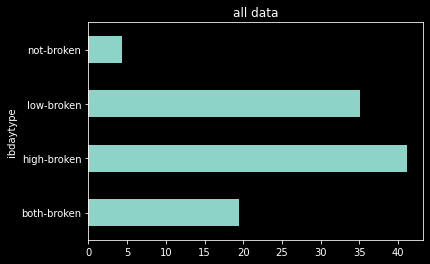

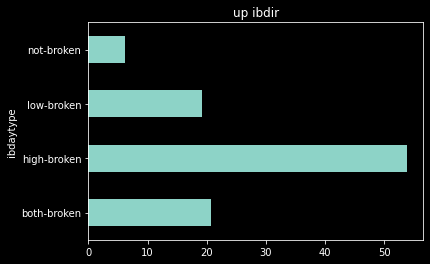

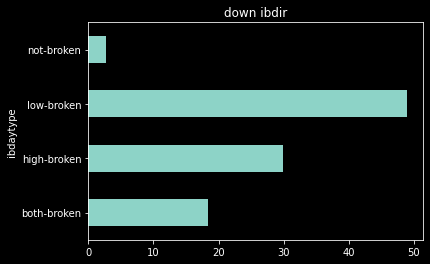

In [12]:
plt.style.use("dark_background")
def plot_ibdaytype(data, title):
    (data.groupby("ibdaytype").date.count() *100 / len(data)).plot.barh(title=title)
    plt.show()


ideas = [
    (data, "all data"),
    (data[data.ibdir == "up"], "up ibdir"),
    (data[data.ibdir == "down"], "down ibdir")
]

for idea in ideas: plot_ibdaytype(idea[0], idea[1])


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       277 non-null    object 
 1   open       277 non-null    float64
 2   high       277 non-null    float64
 3   low        277 non-null    float64
 4   close      277 non-null    float64
 5   iblow      277 non-null    float64
 6   ibhigh     277 non-null    float64
 7   ibclose    277 non-null    float64
 8   range      277 non-null    float64
 9   ibrange    277 non-null    float64
 10  daydir     277 non-null    object 
 11  ibdir      277 non-null    object 
 12  ibdaytype  277 non-null    object 
dtypes: float64(9), object(4)
memory usage: 30.3+ KB


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       277 non-null    object 
 1   open       277 non-null    float64
 2   high       277 non-null    float64
 3   low        277 non-null    float64
 4   close      277 non-null    float64
 5   iblow      277 non-null    float64
 6   ibhigh     277 non-null    float64
 7   ibclose    277 non-null    float64
 8   range      277 non-null    float64
 9   ibrange    277 non-null    float64
 10  daydir     277 non-null    object 
 11  ibdir      277 non-null    object 
 12  ibdaytype  277 non-null    object 
dtypes: float64(9), object(4)
memory usage: 30.3+ KB


In [15]:
data["weekday"] = pd.to_datetime(data["date"]).dt.weekday.astype("str")

In [16]:
data

,date,open,high,low,close,iblow,ibhigh,ibclose,range,ibrange,daydir,ibdir,ibdaytype,weekday
0,2021-03-03,14130.86,14197.49,13979.73,14080.03,14129.55,14197.49,14179.74,217.76,67.94,down,up,low-broken,2
1,2021-03-04,14015.44,14095.81,13959.27,14056.34,13976.44,14056.32,14006.65,136.54,79.88,up,down,both-broken,3
2,2021-03-05,13958.54,14068.03,13868.20,13920.69,13868.20,13970.17,13901.60,199.83,101.97,down,down,high-broken,4
3,2021-03-08,14024.57,14402.92,13977.13,14380.91,13977.13,14050.00,14013.16,425.79,72.87,up,down,high-broken,0
4,2021-03-09,14345.51,14475.65,14309.35,14437.94,14309.35,14403.48,14392.05,166.30,94.13,up,up,high-broken,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2022-03-28,14376.00,14627.58,14371.90,14417.37,14371.90,14527.01,14504.18,255.68,155.11,up,up,high-broken,0
273,2022-03-29,14592.74,14925.25,14553.71,14820.33,14553.71,14664.29,14603.33,371.54,110.58,up,up,high-broken,1
274,2022-03-30,14712.32,14744.72,14555.87,14606.05,14586.01,14744.72,14620.20,188.85,158.71,down,down,low-broken,2
275,2022-03-31,14674.83,14732.00,14404.03,14414.75,14603.31,14732.00,14607.18,327.97,128.69,down,down,low-broken,3


In [17]:
X = data[["open", "iblow", "ibhigh", "ibclose", "ibrange", "ibdir", "weekday"]]
X = pd.get_dummies(X)
X

,open,iblow,ibhigh,ibclose,ibrange,ibdir_down,ibdir_up,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4
0,14130.86,14129.55,14197.49,14179.74,67.94,0,1,0,0,1,0,0
1,14015.44,13976.44,14056.32,14006.65,79.88,1,0,0,0,0,1,0
2,13958.54,13868.20,13970.17,13901.60,101.97,1,0,0,0,0,0,1
3,14024.57,13977.13,14050.00,14013.16,72.87,1,0,1,0,0,0,0
4,14345.51,14309.35,14403.48,14392.05,94.13,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
272,14376.00,14371.90,14527.01,14504.18,155.11,0,1,1,0,0,0,0
273,14592.74,14553.71,14664.29,14603.33,110.58,0,1,0,1,0,0,0
274,14712.32,14586.01,14744.72,14620.20,158.71,1,0,0,0,1,0,0
275,14674.83,14603.31,14732.00,14607.18,128.69,1,0,0,0,0,1,0


# Tak na razie - pierwsza proba 

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
y = data["ibdaytype"]
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 3, 1,
       2, 2, 2, 1, 3, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 2, 2, 1,
       2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 1, 2, 1, 3, 0, 0, 1,
       0, 2, 1, 1, 2, 0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 1, 0, 1,
       2, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 0, 2, 3, 1, 1, 0, 2, 3, 0, 1, 2,
       0, 1, 0, 1, 1, 2, 0, 2, 2, 1, 1, 0, 3, 2, 2, 0, 2, 1, 0, 1, 2, 1,
       0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 3, 2, 2, 0, 2, 1, 0, 1, 1, 2,
       1, 1, 3, 1, 1, 1, 3, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 2,
       2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 3,
       0, 0, 3, 2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0,
       1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 1,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1])

In [20]:
X_train, X_test = train_test_split(X, train_size=0.8)
y_train, y_test = train_test_split(y, train_size=0.8)

In [21]:
clf = XGBClassifier(use_label_encoder=False)
clf.fit(X_train, y_train)

/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [22]:
pred_train = clf.predict(X_train)
pred_train

array([1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 3, 0, 1, 2, 1, 2, 2, 0,
       0, 1, 1, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2,
       2, 0, 0, 1, 1, 1, 2, 1, 3, 0, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1,
       3, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 3, 2, 2,
       2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 1,
       0, 1, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 1, 3, 2, 1, 1, 2, 2, 2, 1, 0,
       1, 2, 1, 3, 1, 2, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 2, 1,
       1])

In [23]:
encoder.inverse_transform(pred_train) # wniosek 1= up ,0 = down

array(['high-broken', 'high-broken', 'low-broken', 'high-broken',
       'both-broken', 'low-broken', 'low-broken', 'high-broken',
       'low-broken', 'low-broken', 'low-broken', 'both-broken',
       'low-broken', 'low-broken', 'not-broken', 'both-broken',
       'high-broken', 'low-broken', 'high-broken', 'low-broken',
       'low-broken', 'both-broken', 'both-broken', 'high-broken',
       'high-broken', 'low-broken', 'low-broken', 'both-broken',
       'both-broken', 'low-broken', 'high-broken', 'both-broken',
       'low-broken', 'high-broken', 'low-broken', 'both-broken',
       'high-broken', 'high-broken', 'high-broken', 'low-broken',
       'low-broken', 'high-broken', 'high-broken', 'low-broken',
       'low-broken', 'both-broken', 'both-broken', 'high-broken',
       'high-broken', 'high-broken', 'low-broken', 'high-broken',
       'not-broken', 'both-broken', 'both-broken', 'high-broken',
       'low-broken', 'low-broken', 'low-broken', 'low-broken',
       'high-broken', 

In [24]:
cross_val_score(clf, X_train, y_train, cv=10).mean()

/home/wit/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[22:33:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:33:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.38003952569169963

In [25]:
predib = encoder.inverse_transform(clf.predict(X_test))
predib

array(['both-broken', 'both-broken', 'both-broken', 'high-broken',
       'high-broken', 'high-broken', 'high-broken', 'both-broken',
       'both-broken', 'both-broken', 'high-broken', 'both-broken',
       'low-broken', 'low-broken', 'high-broken', 'high-broken',
       'both-broken', 'both-broken', 'high-broken', 'high-broken',
       'both-broken', 'high-broken', 'high-broken', 'both-broken',
       'high-broken', 'high-broken', 'low-broken', 'both-broken',
       'high-broken', 'high-broken', 'low-broken', 'high-broken',
       'high-broken', 'low-broken', 'high-broken', 'high-broken',
       'high-broken', 'high-broken', 'high-broken', 'low-broken',
       'high-broken', 'low-broken', 'high-broken', 'not-broken',
       'high-broken', 'high-broken', 'both-broken', 'high-broken',
       'low-broken', 'high-broken', 'high-broken', 'high-broken',
       'low-broken', 'high-broken', 'low-broken', 'high-broken'],
      dtype=object)

In [26]:
actib  = encoder.inverse_transform(y_test)
actib

array(['low-broken', 'low-broken', 'high-broken', 'high-broken',
       'low-broken', 'high-broken', 'low-broken', 'high-broken',
       'low-broken', 'high-broken', 'low-broken', 'high-broken',
       'low-broken', 'high-broken', 'high-broken', 'high-broken',
       'both-broken', 'both-broken', 'low-broken', 'low-broken',
       'not-broken', 'low-broken', 'high-broken', 'low-broken',
       'low-broken', 'high-broken', 'both-broken', 'low-broken',
       'both-broken', 'high-broken', 'high-broken', 'low-broken',
       'not-broken', 'low-broken', 'both-broken', 'low-broken',
       'low-broken', 'high-broken', 'high-broken', 'both-broken',
       'not-broken', 'low-broken', 'high-broken', 'both-broken',
       'both-broken', 'both-broken', 'both-broken', 'both-broken',
       'low-broken', 'high-broken', 'high-broken', 'high-broken',
       'low-broken', 'not-broken', 'high-broken', 'low-broken'],
      dtype=object)

In [29]:
import numpy as np
predib = np.expand_dims(predib, axis=1)
actib = np.expand_dims(actib, axis=1)
d = np.concatenate((predib, actib), axis=1)
d = pd.DataFrame(d.reshape(-1, 2), columns=["pred", "act"])

In [30]:
d.pred.value_counts()

high-broken    27
low-broken     24
both-broken     5
Name: pred, dtype: int64

In [31]:
d.act.value_counts()

high-broken    28
low-broken     16
both-broken    10
not-broken      2
Name: act, dtype: int64

In [32]:
from sklearn.linear_model import LogisticRegression

In [35]:
lr = LogisticRegression(max_iter=3000)
cross_val_score(lr, X_train, y_train).mean()

0.3078787878787878

In [28]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb = XGBClassifier(random_state=1)
param_grid = {
     'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

grid = GridSearchCV(xgb, param_grid=param_grid, cv=5, verbose=False, n_jobs=4)
bestie = grid.fit(X_train, y_train)

/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remov

/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/wit/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_labe